In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
import cmath
from astropy.io import fits

In [58]:
lambda_min = 6000.0
lambda_max = 6100.0
res = 100
wavelengths = np.linspace(lambda_min,lambda_max,res,endpoint=True)

# Gaussian given by:

 $\frac{1}{\sqrt{\pi}\Delta \lambda_d} exp(-(\frac{\lambda - \lambda_0}{\Delta\lambda_d})^2)$ 
 
 It has a FWHM of : $2\Delta\lambda_d\sqrt{ln2}$
 
 # Lorentzian given by:

 $\frac{1}{a\pi \Delta\lambda_d} \frac{a^2 {\Delta\lambda_d}^2}{{(\lambda - \lambda_0)}^2 + a^2 {\Delta\lambda_d}^2}$ 
 
 It has a FWHM of : $2a\Delta\lambda_d$
 
 ### note that in the lorentzian, $a$ is dimensionless and has units of doppler widths...

In [30]:
def voigt(x,delta,sigma):
    exp1 = np.exp((-1j*x + delta)**2.0/(2.0*sigma**2.0))
    mult1= erfc((-1j*x + delta)/(np.sqrt(2.0)*sigma))
    exp2 = np.exp((1j*x + delta)**2.0/(2.0*sigma**2.0))
    mult2= erfc((1j*x + delta)/(np.sqrt(2.0)*sigma))
    
    return np.real((exp1*mult1 + exp2*mult2)/(2.0*np.sqrt(2.0*np.pi)*sigma))
                   


In [31]:
def line_profile(lc,a,dw):
    sigma = dw/np.sqrt(2.0) # definition of doppler width everything is in angstroms
    delta = a # natual width of the line in angstroms
    x=  wavelengths - lc
    return dw*voigt(x,delta,sigma)
    

In [32]:
dw = 6.0
lc = 6050.0

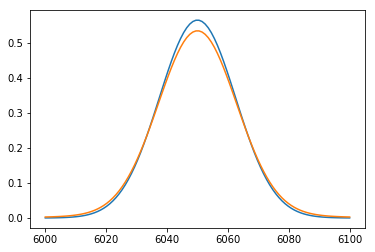

In [61]:
# check with simple milne... works out
plt.plot((wavelengths),line_profile(lc,0.0,dw))
plt.plot((wavelengths),line_profile(lc,dw*0.05,dw))

# Zeeman effect causes things to be profile to be shifted by $\pm \lambda_B = 4.67 \times 10^{−13}\lambda_0^2 B$,

In [35]:
def phi_0(lc,a,dw,lb):
    return line_profile(lc, a, dw)

def phi_r(lc,a,dw,lb):
    return line_profile(lc + lb, a, dw)

def phi_b(lc,a,dw,lb):
    return line_profile(lc - lb, a, dw)


/Users/neku5162/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


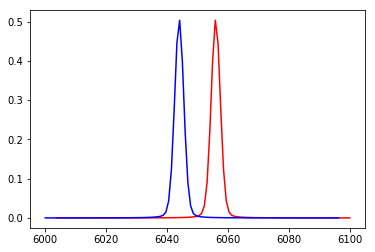

In [9]:
dw = 2.0 # set doppler width to be 2 angstorms
a = 0.2
lc = 6050.0
lb = 6.0
plt.plot(wavelengths,phi_r(lc,a,dw,lb),'r')
plt.plot(wavelengths,phi_b(lc,a,dw,lb),'b')
plt.show()

In [10]:
def nI(n0,lc,a,dw,lb,inc,azi):
    
    p0 = phi_0(lc,a,dw,lb)
    pr = phi_r(lc,a,dw,lb)
    pb = phi_b(lc,a,dw,lb)
    
    return (1.0 + (n0/2.0)*(p0*(np.sin(inc))**2.0 + 0.5*(pb + pr)*(1.0 + (np.cos(inc))**2.0 )))

def nQ(n0,lc,a,dw,lb,inc,azi):

    p0 = phi_0(lc,a,dw,lb)
    pr = phi_r(lc,a,dw,lb)
    pb = phi_b(lc,a,dw,lb)
    
    return (n0/2.0)*( p0 - 0.5*(pb + pr) )*(np.sin(inc))**2.0 * np.cos(2.0*azi)

def nU(n0,lc,a,dw,lb,inc,azi):
    
    p0 = phi_0(lc,a,dw,lb)
    pr = phi_r(lc,a,dw,lb)
    pb = phi_b(lc,a,dw,lb)
    
    return (n0/2.0)*( p0 - 0.5*(pb + pr) )*(np.sin(inc))**2.0 * np.sin(2.0*azi)

def nV(n0,lc,a,dw,lb,inc,azi):

    p0 = phi_0(lc,a,dw,lb)
    pr = phi_r(lc,a,dw,lb)
    pb = phi_b(lc,a,dw,lb)
    
    return (n0/2.0)*(pr - pb) * np.cos(inc)


# ignore magneto-optical effects foor the moment. This depends on the damping parameter. compute later

def rQ(n0,inc,azi,u,ub):
    return 0.0

def rU(n0,inc,azi,u,ub):
    return 0.0

def rV(n0,inc,azi,u,ub):
    return 0.0

In [37]:
n0 = 10.0
lc = 6050.0
dw = 9.0
lb = 2.4*dw
a = 0.05*dw
inc = np.pi/4.0
azi = np.pi/6.0

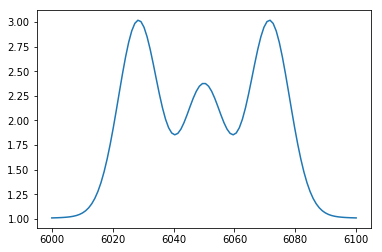

In [38]:
plt.plot(wavelengths,nI(n0,lc,a,dw,lb,inc,azi))

In [39]:
def raw_emerge_I(params):
    
    [n0,lc,a,dw,lb,inc,azi,s1,s0] = params 
    
    #print(n0,lc,a,dw,lb,inc,azi,s1,s0)
    nI_l = nI(n0,lc,a,dw,lb,inc,azi)
    nQ_l = nQ(n0,lc,a,dw,lb,inc,azi)
    nU_l = nU(n0,lc,a,dw,lb,inc,azi)
    nV_l = nV(n0,lc,a,dw,lb,inc,azi)
   
    #print(nI_l)
    
    det = nI_l**2.0 * (nI_l**2.0 - nQ_l**2.0 - nU_l**2.0 - nV_l**2.0)
    
    I0 = s0 + det**(-1.0) * nI_l * (nI_l**2.0) * s1
    Q0 = -1.0*det**(-1.0)*(nI_l**2.0 * nQ_l ) * s1
    U0 = -1.0*det**(-1.0) * (nI_l**2.0 * nU_l ) * s1
    V0 = -1.0*det**(-1.0) * (nI_l**2.0 * nV_l ) * s1
    
    I_cont = I0[0]
    
    stokes = np.array([wavelengths,I0/I_cont,Q0/I_cont,U0/I_cont,V0/I_cont])
    
    return stokes

    

In [40]:
n0 = 10.0
lc = 6050.0
dw = 6.0
lb = 2.4*dw
a = 0.0*dw
inc = np.pi/4.0
azi = np.pi/6.0
s1 = 4.0
s0 = 1.0

ray = raw_emerge_I([n0,lc,a,dw,lb,inc,azi,s1,s0])

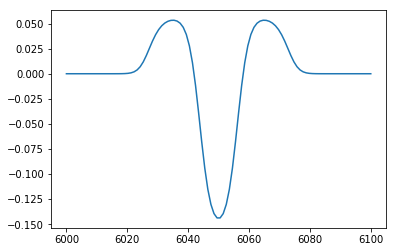

In [63]:
plt.plot(ray[0,:],ray[2,:])

In [44]:
# convex optimization
# optimize minimize
# genetic algorithms **
# downhill simplex method **
# calculate response functions analytically
# compare with library written funcs

In [45]:
from scipy.optimize import minimize

In [18]:
observed = ray

In [19]:
observed.shape

(5, 112)

In [20]:
def chi_sq(x):
    errs = ((observed - raw_emerge_I(x))**2.0).flatten()
    return np.sum(errs)

In [21]:
nI(n0,lc,a,dw,lb,inc,azi)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.00000001, 1.00000002, 1.00000008, 1.00000028, 1.00000089,
       1.00000276, 1.00000815, 1.00002299, 1.00006205, 1.00016006,
       1.00039468, 1.00093029, 1.00209612, 1.00451471, 1.00929527,
       1.01829411, 1.03441741, 1.06189602, 1.1064057 , 1.17485772,
       1.27467719, 1.41245683, 1.59204276, 1.81235798, 2.06552574,
       2.33600268, 2.60135421, 2.83495038, 3.01029358, 3.10609475,
       3.11083322, 3.02555538, 2.86412022, 2.65083152, 2.41612512,
       2.19143196, 2.00437605, 1.87514463, 1.81438827, 1.82260165,
       1.89074156, 2.00184827, 2.1335248 , 2.26114574, 2.36154069,
       2.4166755 , 2.4166755 , 2.36154069, 2.26114574, 2.1335248 ,
       2.00184827, 1.89074156, 1.82260165, 1.81438827, 1.87514463,
       2.00437605, 2.19143196, 2.41612512, 2.65083152, 2.86412022,
       3.02555538, 3.11083322, 3.10609475, 3.01029358, 2.83495

[ 5.70061635e+00  6.05000058e+03  3.55126236e-01  8.89813912e+00
  5.89170044e+00  1.34786308e+00 -9.84119589e-03  5.17129920e+00
  1.36969515e+00]


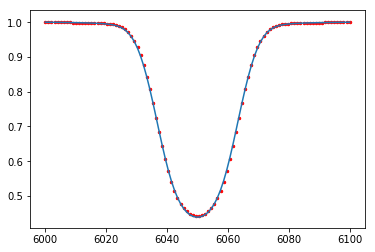

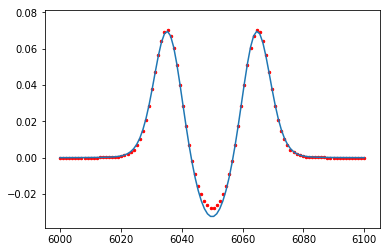

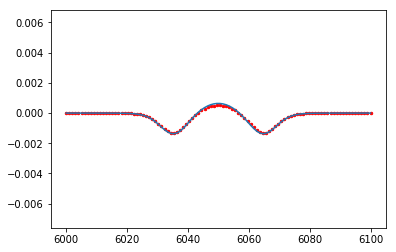

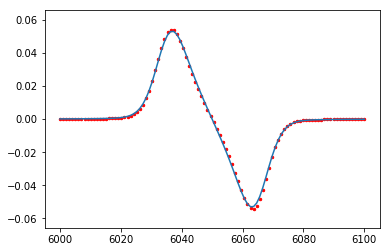

In [80]:
n0 = np.random.uniform(1.0, 10.0)
lc = 6050.0
a = np.random.uniform(0.0, 2.0) 
dw = np.random.uniform(1.0, 20.0)
lb = np.random.uniform(0.0, 10.0)
inc = np.random.uniform(0.0, np.pi)
azi = np.random.uniform(0.0, 2*np.pi)
s1 = np.random.uniform(0.0, 10.0)
s0 = np.random.uniform(0.0, 10.0)

observed = raw_emerge_I([n0,lc,a,dw,lb,inc,azi,s1,s0])

inversion = minimize(chi_sq, [1.0,lc,0.01,4.0,1.0,0.1,0.1,1.0,2.0],method='COBYLA')#

params = inversion.x
print(params)
[n0,lc,a,dw,lb,inc,azi,s1,s0] = params

plt.scatter(observed[0,:],observed[1,:],s=6.0,color = 'red')
inv_spectra = raw_emerge_I([n0,lc,a,dw,lb,inc,azi,s1,s0])
plt.plot(inv_spectra[0,:],inv_spectra[1,:])
plt.show()
plt.scatter(observed[0,:],observed[2,:],s=6.0,color = 'red')
plt.plot(inv_spectra[0,:],inv_spectra[2,:])
plt.show()
plt.scatter(observed[0,:],observed[3,:],s=6.0,color = 'red')
plt.plot(inv_spectra[0,:],inv_spectra[3,:])
plt.show()
plt.scatter(observed[0,:],observed[4,:],s=6.0,color = 'red')
plt.plot(inv_spectra[0,:],inv_spectra[4,:])

plt.show()


In [48]:
hinode = data[0].data

In [25]:
hinode.shape

(512, 744, 4, 112)

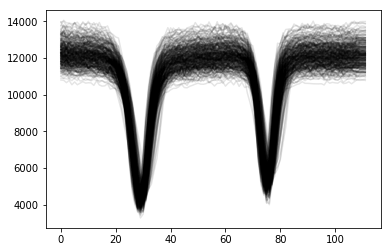

In [26]:
i = np.random.randint(512)
j = np.random.randint(744)
for i in np.arange(300):
    plt.plot(hinode[i,j,0,:],alpha = 0.1,color='black')
plt.show()

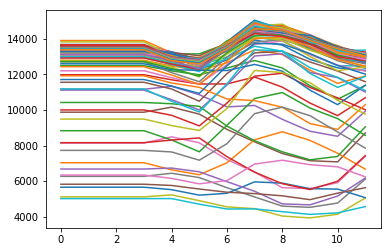

In [27]:
plt.plot([hinode[i,14,0,:]for i in np.arange(12)])